In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
X_train_1 = pd.read_csv('data/dengue_features_train.csv')
y_train = pd.read_csv('data/dengue_labels_train.csv')['total_cases']
attr = list(X_train_1)
attr

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

## Cleaning the noisy training data

In [4]:
def bools_to_indexes(booleans):
    r = []
    for idx, x in enumerate(booleans):
        if x:
            r.append(idx)
    return r

idx = bools_to_indexes(X_train_1['weekofyear'] == 53)
y_train.drop(idx, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_1.drop(idx, inplace=True)
X_train_1.reset_index(drop=True, inplace=True)
X_train_1.shape

(1451, 24)

# Trying models

In [5]:
score_metric='neg_mean_absolute_error'
n_jobs=-1
iid = False
verbose_level = 2
k_folds=10 
n_iter_search=20

## Simple MLP with Scikit-Learn
* First we will try with a simple Multilayer Perceptron.
* According to the book 'Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems', applying the RELU activation function to all the hidden layers is a good idea.
* Here we will simply be searching through the different initial learning rates
* The ideal number of layers appears to be 7, however the scores are still very high.

### Preparing the data

In [8]:
%autoreload
from utils.OurPipeline import create_pipeline

pipeline = create_pipeline(attr, n_weeks=1)
X_train = pipeline.fit_transform(X_train_1)
N, M = X_train.shape
N, M 

(1451, 40)

#### Defining generic values

In [69]:
activation = 'relu'
train_algorithm = 'adam'
learn_rate_mode = 'adaptive'
learn_rate_val = 0.001
batch_size = 200
max_iter = 5000
random_n = 42
tol_val = 1e-4
n_iter_tol = 20
verb=False

early_stop=True
val_faction = 0.1

params = {
    #'hidden_layer_sizes': [sp_randint(30, 52), sp_randint(16, 30), sp_randint(4, 16)],
    'learning_rate_init': sp_uniform(1e-4, 1)
    
}

### 7-layer perceptron

In [77]:
neurons_per_layer = [35, 25, 20, 15, 10]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   35.0s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
        beta_2=0.999, early_stopping=True, epsilon=1e-08,
        hidden_layer_sizes=[35, 25, 20, 15, 10], learning_rate='adaptive',
        learning_rate_init=0.04694728278293715, max_iter=5000, momentum=0.9,
        n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
        random_state=42, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 -20.78080881244646)

### 6-layer perceptron

In [64]:
neurons_per_layer = [35, 25, 15, 10]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   28.4s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
        beta_2=0.999, early_stopping=True, epsilon=1e-08,
        hidden_layer_sizes=[35, 25, 15, 10], learning_rate='adaptive',
        learning_rate_init=0.0866318376475216, max_iter=5000, momentum=0.9,
        n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
        random_state=42, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 -19.513873846292523)

### 5-layer perceptron

In [71]:
neurons_per_layer = [35, 20, 10]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   40.3s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
        beta_2=0.999, early_stopping=True, epsilon=1e-08,
        hidden_layer_sizes=[35, 20, 10], learning_rate='adaptive',
        learning_rate_init=0.134954482930001, max_iter=5000, momentum=0.9,
        n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
        random_state=42, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 -21.349379403662667)

### 4-layer perceptron

In [73]:
neurons_per_layer = [30, 15]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.0s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
        beta_2=0.999, early_stopping=True, epsilon=1e-08,
        hidden_layer_sizes=[30, 15], learning_rate='adaptive',
        learning_rate_init=0.09571433102280714, max_iter=5000, momentum=0.9,
        n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
        random_state=42, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False),
 -21.32883347845756)

## Simple MLP with Keras on top of Tensorflow
* We will just try the amount of layers (6) which gave the ideal results with the Sci-kit API. 
* The first layer cannot use the activation function RELU given that the data was standardized.
* Sigmoid is okay given that its codomain is between 0 and 1 and that the RELU is linear above 0.

In [146]:
learn_rate = 0.0001
optim = optimizers.Adam(lr=learn_rate)
loss_fun = 'mae'

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_199 (Dense)            (None, 35)                1435      
_________________________________________________________________
dense_200 (Dense)            (None, 25)                900       
_________________________________________________________________
dense_201 (Dense)            (None, 15)                390       
_________________________________________________________________
dense_202 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 11        
Total params: 4,536
Trainable params: 4,536
Non-trainable params: 0
___________________________________________________

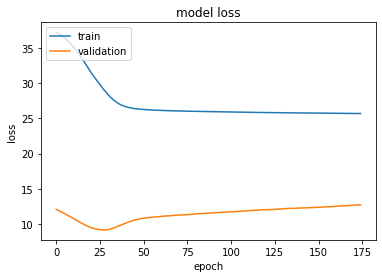

In [148]:
%autoreload
from utils.MLP import create_mlp
neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()

from utils.print_history_loss import print_history_loss

history_fit = network.fit(X_train, y_train, epochs=175, batch_size=150, verbose=0, validation_split=0.5, shuffle=True)
print_history_loss(history_fit)

## Stratified sampling
* The learning curves obtained above are very odd. The validation starts with a very small loss that starts increasing as the model overfits the training data. This is probably because the validation data is very "easy" to predict or all the same. We are going to apply stratified sampling  in order to try and fix this. Y is a continuous variable, therefore stratification is tricky.
* Stratified sampling result was absolutely what we needed as we can see in the learning curves below. It made the train and test data more similar.

In [149]:
from sklearn.model_selection import StratifiedShuffleSplit
#train_strat, test_strat = sss.split(X_train, y_train)

# Create the bins. Given that y is not uniformly distributed at all (as you can see in the analysis notebook histogram), we created bins every 100 values.
y_sorted = np.sort(y_train)
bins = []
for idx, val in enumerate(y_sorted):
    if (idx % 100) == 0:
        bins.append(val)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y_train, bins)

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
for train_index, test_index in sss.split(X_train, y_binned):
    X_train_strat, X_test_strat = X_train[train_index], X_train[test_index]
    y_train_strat, y_test_strat = y_train[train_index], y_train[test_index]
    
X_train_strat.shape, y_train_strat.shape, X_test_strat.shape, y_test_strat.shape

((725, 40), (725,), (726, 40), (726,))

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_205 (Dense)            (None, 35)                1435      
_________________________________________________________________
dense_206 (Dense)            (None, 25)                900       
_________________________________________________________________
dense_207 (Dense)            (None, 15)                390       
_________________________________________________________________
dense_208 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 11        
Total params: 4,536
Trainable params: 4,536
Non-trainable params: 0
___________________________________________________

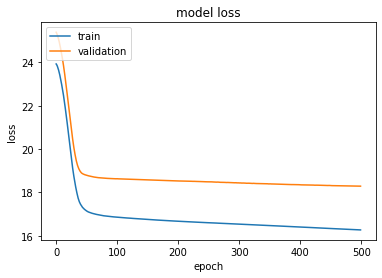

In [150]:
%autoreload
from utils.MLP import create_mlp
neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()

from utils.print_history_loss import print_history_loss

history_fit = network.fit(X_train_strat, y_train_strat, validation_data=(X_test_strat, y_test_strat), epochs=500, batch_size=150, verbose=0, shuffle=True)
print_history_loss(history_fit)

In [88]:
20 % 10

0